In [1]:
import pandas as pd
import pickle
from scipy import spatial
import matplotlib.pyplot as plt


def load_df(path):
    df = pd.read_csv(path)
    return df

def get_distance(point1, point2):
    return spatial.distance.cosine(point1, point2)

def to_floats(vector_str):
    return [float(s) for s in vector_str.split(" ")]
    

In [2]:
def load_run_data(run_index):
    data_path = "../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/run_{:02d}/vectorization_4_packs_1000_samples.csv".format(run_index)
    print(data_path)
    df = load_df(data_path)
    
    df['vector'] = df['vector'].apply(to_floats)
    df.sort_values(by=['entity'], inplace=True)

    max_bucket = df["time_bucket"].max()
    
    dist_data = []
    
    entities_per_bucket = []
    
    all_entities = set()
    
    for bucket_index in range(0, max_bucket+1):
        # print("bucket", bucket_index)
        cur_bucket = df[df["time_bucket"] == bucket_index]
        
        # print(cur_bucket.describe())
        
        entities = cur_bucket['entity'].unique().tolist()
        entities.sort()
        print("{} entities active in bucket {} of {}".format(len(entities), bucket_index+1, max_bucket+1))
        # print(entities)
        entities_per_bucket.append(entities)
        
        all_entities.update(entities)
        
        vector_per_entity = {}
        for index, r in cur_bucket.iterrows():
            entity, vec = r['entity'], r['vector']
            vector_per_entity[entity] = vec
        
        for e1 in entities:
            vec1 = vector_per_entity[e1]
            for e2 in entities:
                if e2 > e1:
                    vec2 = vector_per_entity[e2]
                    # print(e1, e2)
                    dist_data.append([bucket_index, (e1, e2), get_distance(vec1, vec2), vec1, vec2])
                    
        # for index, row in cur_bucket.iterrows():
        #     print(row['vector'])
        
    dist_data_names = ['bucket', 'entities', 'distance', 'vec1', 'vec2']
    dist_df = pd.DataFrame(dist_data, columns=dist_data_names)
    
    dist_df.sort_values(by=['entities'], inplace=True)
    
    # dist_df
    
    all_entity_pairs = dist_df['entities'].unique()
    # print(all_entity_pairs)
    def intersection_size(list1, list2):
        return len(set(list1) & set(list2))
    
    for i in range(1, len(entities_per_bucket)):
        ent1 = entities_per_bucket[i-1]
        ent2 = entities_per_bucket[i]
        # print("Entities intersection between buckets {} and {}: {}".format(i, i+1, intersection_size(ent1, ent2)))
    
    
    
    dist_trends = {ep : [] for ep in all_entity_pairs}
    avg_dist = []
    for bucket_index in range(0, max_bucket+1):
        # print("processing bucket ", bucket_index)
        dist_per_entitypair = {}
        cur_bucket_df = dist_df[dist_df["bucket"] == bucket_index]
        
        for index, r in cur_bucket_df.iterrows():
            dist_per_entitypair[r['entities']] = r['distance']
            
        for entity_pair in all_entity_pairs:
            if entity_pair in dist_per_entitypair:
                dist_trends[entity_pair].append(dist_per_entitypair[entity_pair])
            else:
                dist_trends[entity_pair].append(None)
            
                
        average_distance = cur_bucket_df['distance'].mean()
        avg_dist.append(average_distance)        
    
    avg_dist
    
    return (dist_trends, all_entities)

In [3]:
n_runs = 30
n_buckets = 20

# [Each item is a dict: {(pair of entities) -> [distances, one per bucket]}]
trends = []
all_entities = set()
for i in range(n_runs):
    (run_data, ents) = load_run_data(i+1)
    trends.append(run_data)
    all_entities = ents
    
def get_diff(list_with_nans):
    diff = []
    for i in range(1, len(list_with_nans)):
        has_nans = list_with_nans[i-1] is None or list_with_nans[i] is None
        diff.append(None if has_nans else list_with_nans[i] - list_with_nans[i-1])
    return diff

diff_trends = []
distances_per_run = []
for i in range(n_runs):
    diff_trends.append({p: get_diff(trends[i][p]) for p in trends[i].keys()})
    distances_per_run.append({p: trends[i][p] for p in trends[i].keys()})
    



../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/run_01/vectorization_4_packs_1000_samples.csv
23 entities active in bucket 1 of 20
24 entities active in bucket 2 of 20
28 entities active in bucket 3 of 20
36 entities active in bucket 4 of 20
41 entities active in bucket 5 of 20
45 entities active in bucket 6 of 20
49 entities active in bucket 7 of 20
49 entities active in bucket 8 of 20
54 entities active in bucket 9 of 20
59 entities active in bucket 10 of 20
64 entities active in bucket 11 of 20
68 entities active in bucket 12 of 20
68 entities active in bucket 13 of 20
71 entities active in bucket 14 of 20
79 entities active in bucket 15 of 20
81 entities active in bucket 16 of 20
87 entities active in bucket 17 of 20
71 entities active in bucket 18 of 20
75 entities active in bucket 19 of 20
82 entities active in bucket 20 of 20
../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/run_02/vectorization_4_packs_1000_samples.csv
23 entities active in b

In [4]:

def count_sign_match(diff_a, diff_b):
    match_count = 0
    mismatch_count = 0
    for i in range(len(diff_a)):
        if diff_a[i] is not None:
            match = (diff_a[i] * diff_b[i]) > 0
            if match:
                match_count+=1 
            else:
                mismatch_count += 1
    return {"match": match_count, "mismatch": mismatch_count}


def compare_diff_trends(trend_a, trend_b):
    match_count = 0
    mismatch_count = 0
    for pair in trend_a.keys():
        match_counts = count_sign_match(trend_a[pair], trend_b[pair])
        match_count+=match_counts["match"]
        mismatch_count+=match_counts["mismatch"]
    return {"match": match_count, "mismatch": mismatch_count}

In [5]:
red = pickle.load(open("../pythonminer/out/intellij-community/generated_data_30x_1Ksamples/reversed_entity_dict.pkl", 'rb'))

def get_name(entity):
    return red[entity]['names'][0]

for e in all_entities:
    print("{}: {}".format(e, get_name(e)))
    
print("Total {} entities".format(len(all_entities)))

2.0: Dave Griffith
3.0: Artem Bochkarev
4.0: Ilya.Kazakevich
6.0: Sergei Vorobyov
8.0: Danila Ponomarenko
13.0: Ivan Semenov
14.0: Constantine Plotnikov
17.0: Eugene Zhuravlev
18.0: pasynkov
22.0: Ilya Sergey
25.0: Rustam Vishnyakov
27.0: Ekaterina.Tuzova
28.0: sergey.vasiliev
31.0: Roman
35.0: Artemiy Sartakov
49.0: Oleg Shpynov
50.0: Anton.Makeev
51.0: Valentina Kiryushkina
55.0: Julia Beliaeva
56.0: Valentin Fondaratov
59.0: Peter Gromov
62.0: Aleksey Pivovarov
63.0: med_vector
68.0: Dmitry Avdeev
73.0: Shaverdova Elena
78.0: Maxim Medvedev
79.0: Konstantin Aleev
80.0: Anton Lobov
81.0: Anna.Gromova
84.0: develar
85.0: Kirill.Safonov
86.0: (dboulytchev@gmail.com)
88.0: Gregory Shrago
89.0: Alexandr Suhinin
99.0: Olesya Smirnova
100.0: Anna Kozlova
114.0: Alexander Koshevoy
115.0: Ekaterina Shliakhovetskaja
120.0: sashakirill
125.0: Dmitry Jemerov
126.0: Maxim Mossienko
134.0: Leonid Bushuev
136.0: Alexander Lobas
138.0: Yaroslav Lepenkin
139.0: Vassiliy Kudryashov
142.0: Nikita Skvo

In [6]:
def extract_trend_stats(pair, diff_trends):
    na_count = diff_trends[0].count(None)
    positive_counts = []
    negative_counts = []
    sums = []
    for i in range(len(diff_trends[0])):
        if (diff_trends[0][i]) is not None:
            pos_count = 0
            neg_count = 0
            sum = 0
            for trend_index in range(len(diff_trends)):
                d = diff_trends[trend_index][i]
                if d > 0:
                    pos_count+=1
                else: 
                    neg_count+=1
                sum+=d
            positive_counts.append(pos_count)
            negative_counts.append(neg_count)
            sums.append(sum)
        else: 
            positive_counts.append(None)
            negative_counts.append(None)
            sums.append(None)
    return {
        'entities': pair,
        'names': (get_name(pair[0]), get_name(pair[1])),
        'na_count': na_count,
        'negative_counts': negative_counts,
        'positive_counts': positive_counts,
        'sums': sums
    }            
            

def get_diff_stats(diff_trends_per_run):
    all_pairs = diff_trends_per_run[0].keys()
    diff_stats = []
    for p in all_pairs:
        diff_trends_for_pair = [diff_trends_per_run[i][p] for i in range(len(diff_trends_per_run))]
        stats_for_pair = extract_trend_stats(p, diff_trends_for_pair)
        if stats_for_pair['na_count'] < n_buckets - 1:
            diff_stats.append(stats_for_pair)
    return diff_stats
        

In [7]:
trend_stats = get_diff_stats(diff_trends)

def extract_bucket_stats(trend_stats, bucket_edge_index):
    entries = []
    for ts_row in trend_stats:
        dist_diff = ts_row['sums'][bucket_edge_index]
        if dist_diff is not None:
            entries.append({
                'entities': ts_row['entities'],
                'names': ts_row['names'],
                'distance_diff': dist_diff
            })
    entries = sorted(entries, key = lambda e: e['distance_diff'])
    
    bucket_stats = {
        'bucket1': bucket_edge_index + 1,
        'bucket2': bucket_edge_index + 2,
        'entries': entries
    }
    return bucket_stats

for bucket in range(n_buckets-1):
    bs = extract_bucket_stats(trend_stats, bucket)
    print("Most prominent relative distance changes between buckets {} and {}, summed across {} runs".format(bs['bucket1'], bs['bucket2'], n_runs))
    for ei in range(50):
        entry = bs['entries'][ei]
        print("{}(entity {}) and {}({}): {}".format(
            entry['names'][0],
            entry['entities'][0],
            entry['names'][1],
            entry['entities'][1],
            entry['distance_diff']
        ))
    print("\n")
    
    

Most prominent relative distance changes between buckets 1 and 2, summed across 30 runs
Anna Kozlova(entity 100.0) and Kirill Kalishev(168.0): -5.210301321310772
sergey.vasiliev(entity 28.0) and Anna Kozlova(100.0): -4.0749823736253195
Gregory Shrago(entity 88.0) and Alexey Pegov(298.0): -3.1444387467964408
Anna Kozlova(entity 100.0) and Alexander Kitaev(279.0): -3.046401891705041
Kirill Kalishev(entity 168.0) and Bas Leijdekkers(207.0): -2.875160647159999
Peter Gromov(entity 59.0) and Kirill Kalishev(168.0): -2.7823379340381322
Alexey Pegov(entity 298.0) and Eugene Vigdorchik(336.0): -2.7797657415483497
Anna Kozlova(entity 100.0) and Alexey Pegov(298.0): -2.6734454337876654
Gregory Shrago(entity 88.0) and Kirill Kalishev(168.0): -2.489851689500403
Gregory Shrago(entity 88.0) and Alexander Kitaev(279.0): -2.45112581260776
sergey.vasiliev(entity 28.0) and Gregory Shrago(88.0): -2.3944690367755737
Dmitry Avdeev(entity 68.0) and Anna Kozlova(100.0): -2.296518618394035
Kirill Kalishev(enti

In [8]:
def show_distance_trend(id1, id2, pdf_name):
    pair = (id1, id2)
    distances_for_pair = []
    for i in range(n_runs):
        distances_for_pair.append(distances_per_run[i][pair])
    print(distances_for_pair)
    avg_distances_across_all_runs = []
    for b in range(n_buckets):
        dist = 0
        for i in range(n_runs):
            d = distances_for_pair[i][b]
            if d is not None:
                dist+=d
        avg_distances_across_all_runs.append(dist / n_runs)
        
    print(avg_distances_across_all_runs)
    
    f = plt.figure()
    plt.scatter(range(n_buckets), avg_distances_across_all_runs)
    plt.figtext(0, 0, "Distance between {} and {}".format(get_name(id1), get_name(id2)))
    plt.show()
    f.savefig(pdf_name)
    
  

[[None, None, None, None, None, None, None, None, None, None, 0.04238790845227658, 0.020599993563665486, 0.08546523368117909, 0.07822506714385713, 0.016605769019484518, 0.07426342570196387, 0.020518339438468924, 0.4485068292856321, 0.046942555562133226, 0.01108226260861167], [None, None, None, None, None, None, None, None, None, None, 0.07698537620792112, 0.09630256299058415, 0.0311275140320727, 0.11236676645611277, 0.046774203197123665, 0.10663963705958746, 0.07502551348649722, 0.11852220415481907, 0.21125258551767612, 0.12164506811407128], [None, None, None, None, None, None, None, None, None, None, 0.02128066088048397, 0.04964093354251109, 0.12492040079613342, 0.1411342231910988, 0.05970285082602422, 0.263729757132917, 0.04303117760587449, 0.13615450443616994, 0.359152544123605, 0.1226936885284241], [None, None, None, None, None, None, None, None, None, None, 0.012247969395052127, 0.11269593854050985, 0.16923645032835966, 0.1969044742197108, 0.13338838749098092, 0.14690996091531316,

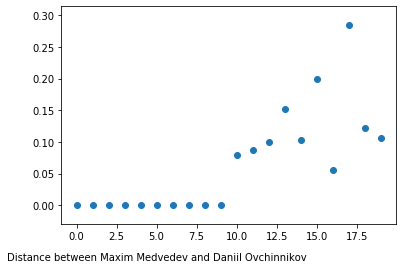

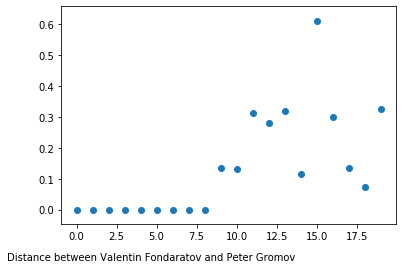

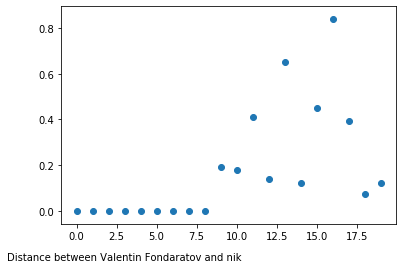

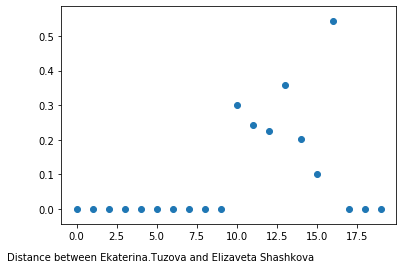

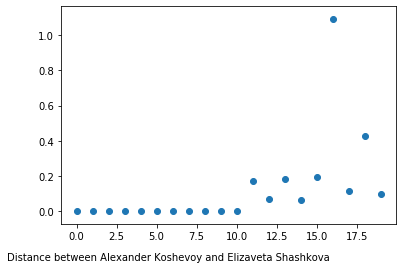

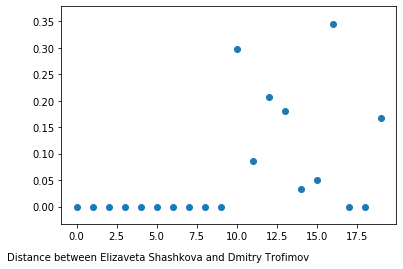

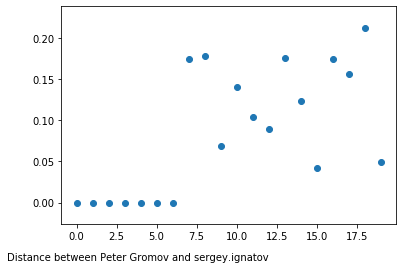

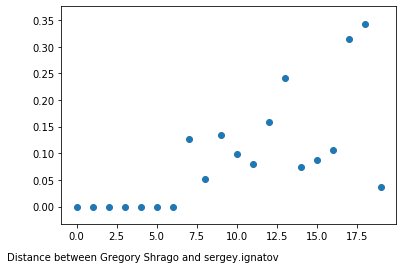

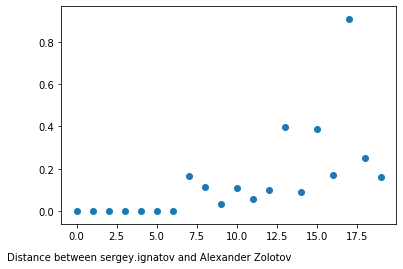

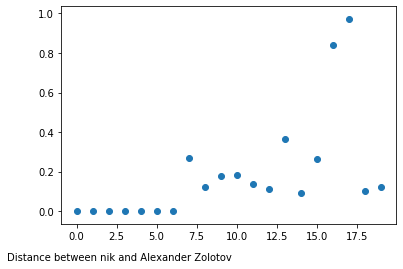

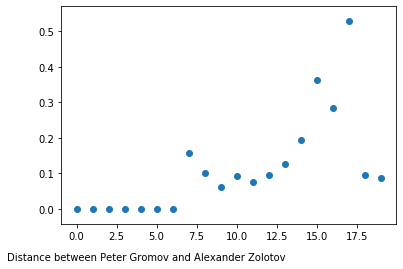

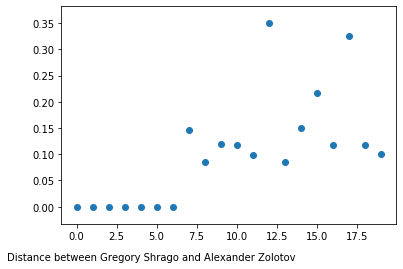

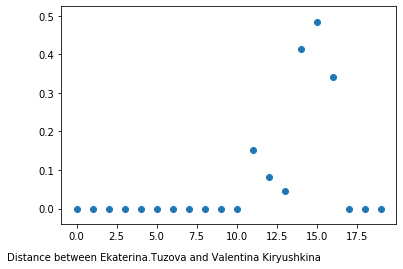

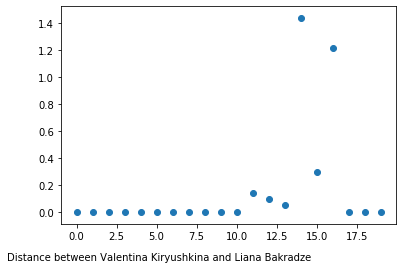

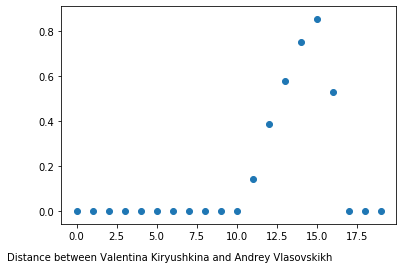

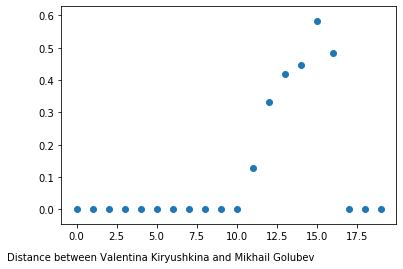

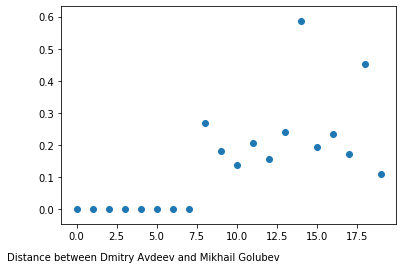

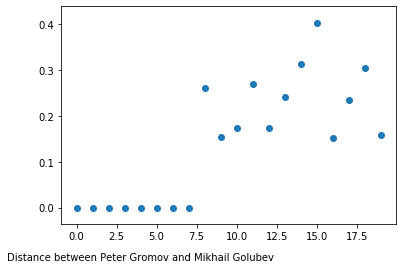

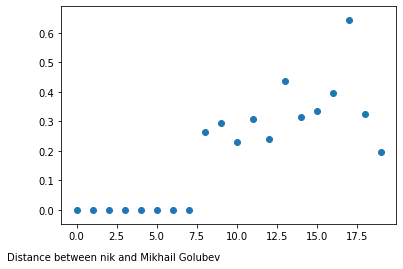

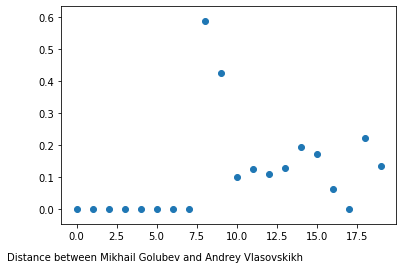

In [9]:
#POSITIVE  
pos_examples = []
pos_examples.append((78, 491))
pos_examples.append((56, 59))
pos_examples.append((56, 179))
pos_examples.append((27, 286))
pos_examples.append((114, 286))
pos_examples.append((286, 338))
pos_examples.append((59, 182))
pos_examples.append((88, 182))
pos_examples.append((182, 282))
pos_examples.append((179, 282))
pos_examples.append((59, 282))
pos_examples.append((88, 282))
pos_examples.append((27, 51))
pos_examples.append((51, 274))
pos_examples.append((51, 265))
pos_examples.append((51, 199))
pos_examples.append((68, 199))
pos_examples.append((59, 199))
pos_examples.append((179, 199))
pos_examples.append((199, 265))

for pe in pos_examples:
    show_distance_trend(pe[0], pe[1], "pos_{}_{}.pdf".format(pe[0], pe[1]))


[[None, None, None, None, None, None, None, None, None, None, None, None, None, 0.11108241245685668, 0.16116026606511402, 0.021109351050306646, 0.16450874793148218, 0.31164047366423786, 0.39039756837384976, 0.2019850656085589], [None, None, None, None, None, None, None, None, None, None, None, None, None, 0.10779004832482086, 0.28105039942855314, 0.129620026927748, 0.3097948321648917, 0.14083234620957152, 1.1043192646263462, 0.545662464832269], [None, None, None, None, None, None, None, None, None, None, None, None, None, 0.09892139396790123, 0.20604733489864724, 0.04191856608236444, 0.18802801927868862, 0.24071246193362172, 0.3931793299050438, 0.43188315071809835], [None, None, None, None, None, None, None, None, None, None, None, None, None, 0.21540615881616587, 0.5263619113356537, 0.038850074838616355, 0.6146054224654898, 0.22379240263052658, 1.1514764732389635, 0.7874486378456582], [None, None, None, None, None, None, None, None, None, None, None, None, None, 0.0900807325441676, 0.

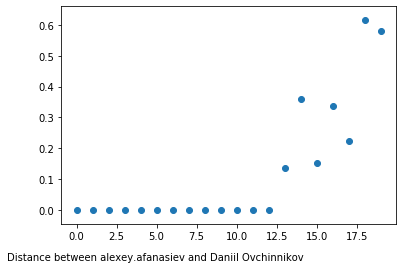

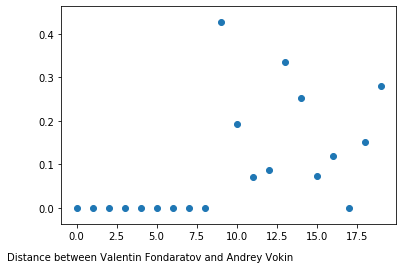

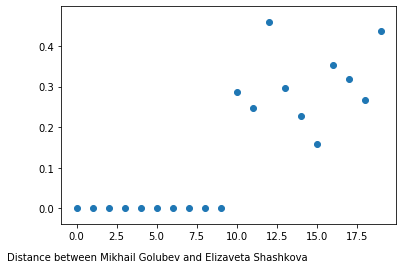

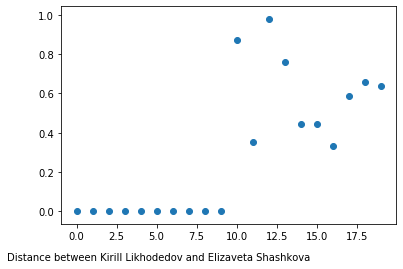

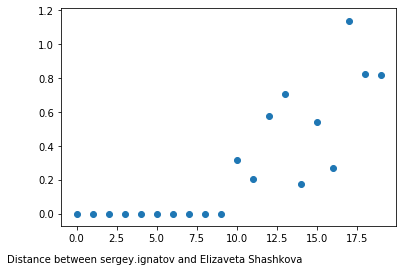

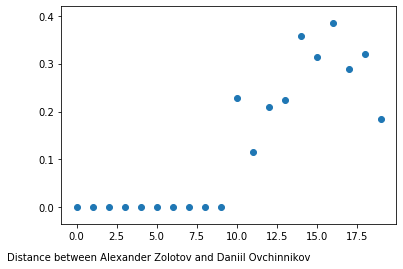

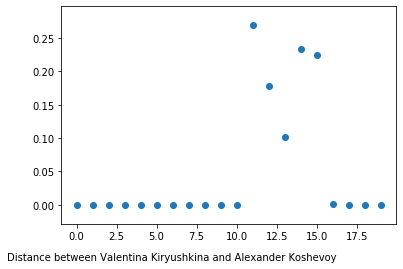

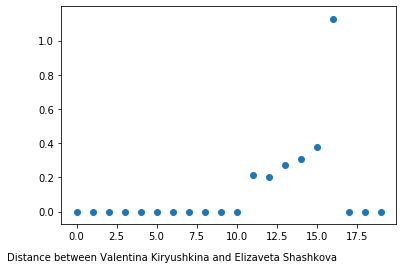

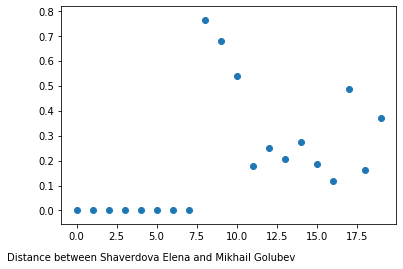

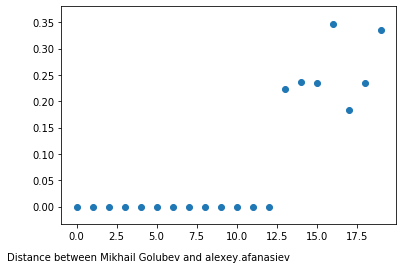

In [10]:
#NEGATIVE
neg_examples = []
neg_examples.append((240, 491))
neg_examples.append((56, 221))
neg_examples.append((199, 286))
neg_examples.append((228, 286))
neg_examples.append((182, 286))
neg_examples.append((282, 491))
neg_examples.append((51, 114))
neg_examples.append((51, 286))
neg_examples.append((73, 199))
neg_examples.append((199, 240))

for ne in neg_examples:
    show_distance_trend(ne[0], ne[1], "neg_{}_{}.pdf".format(ne[0], ne[1]))